In [1]:
import re
from collections import Counter
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 章回数
CHAPTER_NUM = 80

引子
===
<font style="font-family:chalkboard;georgia;font-size:1.4em;" >
金庸創作很多武俠小說，但是也常因為忙，曾經請人代筆，譬如倪匡。這裡將示範如何利用機器學習的技巧，
判別作品集是否為金庸本人創作。同時也介紹一些常用的技巧，歡迎各位同事引用，新年快樂。

</font>

Example
---
<font style="font-size:1.4em;color:brown;" >
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;射雕前傳，射雕英雄傳 是否為同一個作者創作？
</font>

Data Processing
---
<font style="font-family:chalkboard;georgia;font-size:1.4em;" >
1. Cut the book into individual chapters and saved.  分割章節
- clean the redundant symbols, line return blank space, for instance, 去除跳行, 空格等的符號
- try to delete the redundant characters or noun: 去除不重要的文字<br>
    <pre>'此', '地', '才', '日', '經', '便', '看', '出', '：', '沒'</pre>
- compute frequency of words found 計算分詞的頻率
- quantify  each chapters based on above and make visualization 量化每一章的數量, 並且畫圖顯示
- judge the style by the prediction of K Nearest Neighbor method 使用機器學習 KNN 決定每一個章節的格式

In [4]:
def cut_book_to_chapter(book_path, save_path_prefix):
  chapter_begin_pattern = '[('
  chapter_end_pattern = '(本章完)'
  
  #import ipdb; ipdb.set_trace()
  with open(book_path, 'r', encoding = 'utf-8') as f:
    book = f.read()

  beg_pos =  book.find(chapter_begin_pattern)
  chapter_index = 1
  while beg_pos != -1:
    end_pos = book.find(chapter_end_pattern, beg_pos)
    end_pos += len(chapter_end_pattern)

    current_chapter = book[beg_pos:end_pos+1]
    current_chapter_path = save_path_prefix + str(chapter_index)
    with open(current_chapter_path, 'w', encoding = 'utf-8') as f:
      f.write(current_chapter)
    
    beg_pos = book.find(chapter_begin_pattern, end_pos)
    chapter_index += 1


In [5]:
# 对每一章节预处理
def preprocess_chapter(raw_text):
  # 去除第一行和最后一行
  pos1 = raw_text.find('\n')
  pos2 = raw_text.rfind('\n')
  chapter = raw_text[pos1:pos2].strip()
  # 去除空格和换行符号
  chapter = re.sub('[\s]', '', chapter)
  
  return chapter

In [6]:
# 找到每一回都出现的字，即停用字
def get_stop_chars(dir_prefix):
  stop_chars = set()
  for i in range(1, CHAPTER_NUM+1):
    file_path = dir_prefix + str(i)
    # 读取章节文本
    with open(file_path, 'r', encoding = 'utf-8') as f:
      raw_text = f.read().strip()
    # 预处理
    chapter = preprocess_chapter(raw_text)
    # 求每个章节的交集 
    if i == 1:
      stop_chars = set(chapter)
    else:
      stop_chars &= set(chapter)

  return list(stop_chars)


In [7]:
# 求出每个停用字的字频，保存到向量中
def convert_chapter_to_vector(chapter, stop_chars):
  # 得到每个字的出现次数
  char_counter = Counter(chapter)
  # 得到该回目总字数 
  chapter_char_num = sum(char_counter.values())
  # 当前回目的特征向量
  feature_vector = np.zeros(len(stop_chars), dtype='float32')
  for i, c in enumerate(stop_chars):
    feature_vector[i] = char_counter[c]
  feature_vector /= chapter_char_num
  
  return feature_vector

In [8]:
# 将每一章节的向量作为一行，构成矩阵
def convert_book_to_matrix(dir_prefix, stop_chars):
  observations = np.zeros((CHAPTER_NUM, len(stop_chars)), dtype='float32')

  for i in range(1, CHAPTER_NUM+1):
    file_path = dir_prefix + str(i)
    # 读取章节文本
    with open(file_path, 'r', encoding = 'utf-8') as f:
      raw_text = f.read().strip()
    # 预处理
    chapter = preprocess_chapter(raw_text)
    # 得到当前回目的向量
    observations[i-1, :] = convert_chapter_to_vector(chapter, stop_chars) 

  return observations

In [9]:
# 降维到3维，并可视化

def scatters_in_3d(samples, is_labelled = False):
  # PCA 降维到2维便于可视化
  pca = PCA(n_components=3)
  reduced_data = pca.fit_transform(samples)

  fig = plt.figure(figsize=(12,10))
  plt.rcParams.update({'font.size': 22})  
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=9, azim=-170)
  for c,  rng in [('r', (0, 40)), ('b', (40, 80))]:
    xs = reduced_data[rng[0]:rng[1], 0]
    ys = reduced_data[rng[0]:rng[1], 1]
    zs = reduced_data[rng[0]:rng[1], 2]
    ax.scatter(xs, ys, zs, c=c)


  ax.w_xaxis.set_ticklabels([])
  ax.w_yaxis.set_ticklabels([])
  ax.w_zaxis.set_ticklabels([])

  if is_labelled:
    for ix in np.arange(len(samples)):
      ax.text(reduced_data[ix, 0], reduced_data[ix, 1],reduced_data[ix, 2],
          str(ix+1), verticalalignment='center', fontsize=14)
  plt.show()

In [10]:
# 构建训练数据并用kNN分类器分类
def knn_clf(observations, n_neighbors):
  # 构建训练数据
  range1 = [15, 25]
  len1 = len(list(range(range1[0], range1[1])))
  range2 = [45, 65]
  len2 = len(list(range(range2[0], range2[1])))

  training_index = list(range(range1[0], range1[1])) + list(range(range2[0],
    range2[1]))
  training_data = observations[training_index, :]
  training_label = np.ones(len1+len2, dtype='int32')
  training_label[len1:] = 2
  # 最近邻分类器
  knn = KNeighborsClassifier(n_neighbors = 3)#, weights = 'distance')
  knn.fit(training_data, training_label) 
  # 预测
  knn_pre = knn.predict(observations)

  print('射雕前傳')
  for i in range(4):
    print((knn_pre[i*10:(i+1)*10]))

  print('射雕英雄傳')
  for i in range(4,8):
    print((knn_pre[i*10:(i+1)*10]))
  print("\n1: 射雕前傳格式, 2: 射雕英雄傳格式,")

In [13]:
chapter_prefix = 'data/chapter-'
cut_book_to_chapter('novels/射雕.txt', chapter_prefix)

In [14]:
stop_chars = get_stop_chars(chapter_prefix)

In [16]:
observations = convert_book_to_matrix(chapter_prefix, stop_chars)

射雕前傳 1-40 章 (紅) 射雕英雄傳 41-80 章 (藍)
---
<font style="font-family:georgia;font-size:1.4em;" >
Obviously, they are different with each other, 很明顯, 兩者相似度偏離

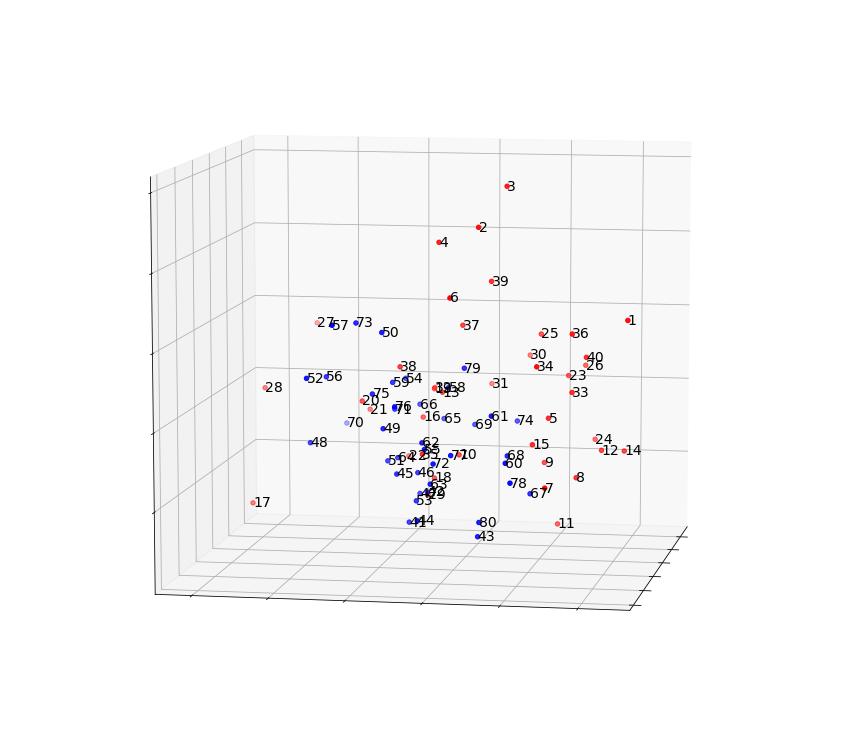

In [17]:
scatters_in_3d(observations, True)

K Nearest Neighbor Model
---
<font style="font-family:georgia;font-size:1.2em;" >

Take chapters 15-25 of 射雕前傳 and chapters 5-25 of 射雕英雄傳 as training set and predict all the chapters of these two books, <br>
使用射雕前傳 15-25 章, 射雕英雄傳 5-25 章 作為訓練集:

1: 射雕前傳格式, 2: 射雕英雄傳格式,

In [19]:
knn_clf(observations, 3)

射雕前傳
[2 2 2 2 1 2 2 1 1 1]
[1 1 1 1 2 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 2 2 2 2 2 2 2]
射雕英雄傳
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]

1: 射雕前傳格式, 2: 射雕英雄傳格式,


Conclusion
---
<font style="font-family:georgia;font-size:1.4em;" >
These conclude the result: different style, different author! <br>
 `射雕前傳` 和 `射雕英雄傳` 書寫格式極為不同, 極有可能為不同人創作

In [20]:
import os, codecs  
import jieba  
import jieba.analyse
from collections import Counter  
import json
import pandas as pd
import gensim
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

%matplotlib inline

Using TensorFlow backend.
/Users/cch/anaconda36/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [21]:
def get_words(txt):
    # load dictionary 
    jieba.load_userdict("names.txt")
    # parse the article
    seg_list = jieba.cut(txt)
    # frequency count
    c = Counter()  
    for x in seg_list:  
        if len(x)>1 and x != '\r\n':  
            c[x] += 1
    # output the result        
    print('常用詞頻率统計結果')  
    for (k,v) in c.most_common(100):  
        print('%s%s %s  %d' % ('  '*(5-len(k)), k, '*'*int(v/3), v))
    return c    

How Machine Learning (ML) works with Literature 
---
機器學習和文學 
---
<p>
<font style="font-family:georgia;font-size:1.2em;" >

Skills of ML help to filter out the features of articles rapidly, <br>
可以快速篩檢出來文章的資料, 以金庸武俠小說, 射雕前傳,(懷疑) 為例

1. 關鍵字頻率 frequencies of keywords
- 相關性 correlation
- 群組關係 relation by group, categorization
- 類比關係 association
- 關係圖 visualization

In [24]:
with codecs.open('novels/射雕前傳.txt', 'r', 'utf8') as f:  
     txt = f.read()  
c1=get_words(txt) 

常用詞頻率统計結果
      藥師 *******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************  1389
      自己 *******************************************************************************************************************************************************  454
      馮蘅 *****************************************************************************************************  303
      黃藥 ****************************************************************************************************  302
      心中 *****************************************************************************************  268
      什么 *

In [23]:
with codecs.open('novels/射雕前傳.txt', 'r', 'utf8') as f:  
     txt = f.read() 
tags = jieba.analyse.extract_tags(txt, topK=30)
print("關鍵詞:")
print(" ".join(tags))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/y0/3qdcxwtx6jb5mfpzd6pgk6hw0000gn/T/jieba.cache
Loading model cost 1.025 seconds.
Prefix dict has been built succesfully.


關鍵詞:
藥師 馮蘅 黃藥 林慕寒 重陽 林慕 師父 一聲 叫道 陽鋒 周伯通 起來 武功 岳詩琪 自己 心下 道長 心中 阿蘅 二人 洪七公 原來 哈哈 鐵崖 爺爺 曲靈 大哥 鐵掌 曲靈風 小蘅


In [7]:
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager
font_chinese = FontProperties(fname="/Library/Fonts/Songti.ttf")

In [8]:
from matplotlib import rcParams
import matplotlib.font_manager as font_manager


In [11]:
#import codecs

with codecs.open('names.txt', encoding="utf8") as f:
    # 去掉结尾的换行符
    data = [line.strip() for line in f]

novels = data[::2]
names = data[1::2]

novel_names = {k: v.split() for k, v in zip(novels, names)}

#for name in novel_names['射雕英雄傳']:
#    print(name)

In [13]:
font_chinese = FontProperties(fname="fireflysung.ttf")
font_bold = FontProperties(fname="/Library/Fonts/Songti.ttf")
rcParams.update({'font.size': 20})

def find_main_charecters(novel, num=10):
    with codecs.open('novels/{}.txt'.format(novel), encoding="utf8") as f:
        data = f.read()
    chars = novel_names[novel]
    count = [data.count(x) for x in chars]

    b=sorted(zip(chars,count),key=lambda x:x[1])
    n=[]
    freq=[]
    for (k,v) in b[-num:]: 
        n.append(k)
        freq.append(v)

    plt.figure(figsize=(12,6))
    plt.title(novel, fontproperties=font_chinese,fontsize=22)
    plt.xlabel("詞彙頻率", fontproperties=font_chinese,fontsize=16)
    plt.yticks(list(range(num)), n[-num:], fontproperties=font_chinese,fontsize=16)
    plt.barh(list(range(num)),freq[-num:])

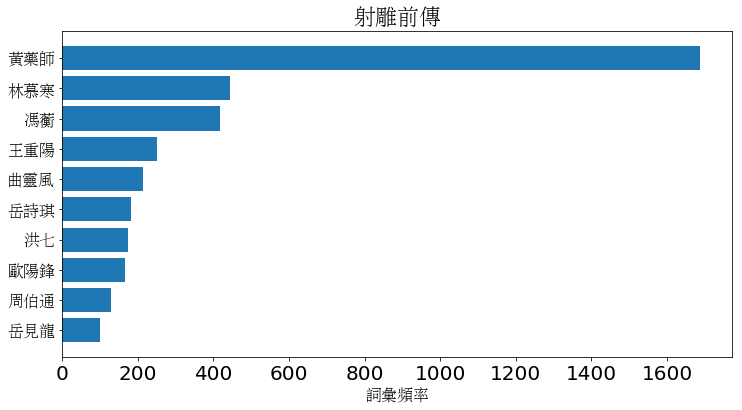

In [14]:
find_main_charecters("射雕前傳")

In [15]:
for _, names in novel_names.items():
    for name in names:
        jieba.add_word(name)

with codecs.open("kungfu.txt", encoding="utf8") as f:
    kungfu_names = [line.strip() for line in f]
with codecs.open("bangs.txt", encoding="utf8") as f:
    bang_names = [line.strip() for line in f]

for name in kungfu_names:
    jieba.add_word(name)

for name in bang_names:
    jieba.add_word(name)

In [21]:
def find_relationship(a, b, c):
    """
    返回 d 
    a to b， like  c to d     
    """
    d, _ = model.most_similar(positive=[c, b], negative=[a])[0]
    print("“{}” 與 “{}” 的關係，  如同 “{}” 和 “{}” 的關係".format(a, b, c, d))

Categorized the Cast
---

In [16]:
#novels = ["射雕前傳","神雕俠侶","射雕英雄傳"]
novels = ["射雕前傳"]
sentences = []

for novel in novels:
    print("處理：{}".format(novel))
    with codecs.open('novels/{}.txt'.format(novel), encoding="utf8") as f:
        sentences += [list(jieba.cut(line.strip())) for line in f]

處理：射雕前傳


In [19]:
model0 = gensim.models.Word2Vec(sentences, size=100, window=5, 
                               min_count=5, workers=4)

In [20]:
for k, s in model0.most_similar(positive=["黃藥師"]):
    print(k, s)

聽 0.9992106556892395
呵呵 0.9987829327583313
又 0.9987250566482544
曲靈風 0.9980761408805847
馮蘅 0.9969958662986755
問 0.9968080520629883
續道 0.9966773390769958
拱手 0.9966106414794922
嘆了 0.9965618848800659
洪七公 0.9963181018829346


In [22]:
def find_relationship(a, b, c):
    """
    返回 d 
    a to b， like  c to d     
    """
    d, _ = model0.most_similar(positive=[c, b], negative=[a])[0]
    print("“{}” 與 “{}” 的關係，  如同 “{}” 和 “{}” 的關係".format(a, b, c, d))

Association 
---

In [25]:
find_relationship("黃藥師",'歐陽鋒',"周伯通")

“黃藥師” 與 “歐陽鋒” 的關係，  如同 “周伯通” 和 “楊遜之” 的關係


In [26]:
all_names = np.array([c for c in novel_names["射雕前傳"] if c in model0])
word_vectors = np.array([model0[c] for c in all_names])

Cast Categorized
---

In [27]:
N = 3

label = KMeans(N).fit(word_vectors).labels_

for c in range(N):
    print("\n類别{}：".format(c+1))
    for idx, name in enumerate(all_names[label==c]):
        print(name, end=' ')
        if idx % 10 == 9:
            print() 
    print()


類别1：
洪七 公孫書寧 林朝英 燕馭軻 公孫嘆 朱熹 岳珂 寧宗 趙擴 段智興 
辛棄疾 陳璧 陳青眉 史威信 武眠風 陸阡 

類别2：
黃藥師 馮蘅 林慕寒 王重陽 歐陽鋒 岳詩琪 周伯通 曲靈風 郭旌陽 楊鐵崖 
獨孤 馬鈺 岳見龍 趙宗印 小蘅 神合子 邱處機 蔣振宇 參寥 慧才 


類别3：
路不平 有天道長 蕭洞玄 杜夢乾 孫不二 戴復古 馬昭容 趙湛 歐陽隱 李晞古 
柯鎮惡 柯辟邪 楊遜之 郭元振 陳處晉 武三通 朱子柳 梅超風 俅千仞 陳玄風 
陸乘風 馮默風 梅若華 


In [28]:
N = 4

c = sp.stats.mode(label).mode

remain_names = all_names[label!=c]
remain_vectors = word_vectors[label!=c]
remain_label = KMeans(N).fit(remain_vectors).labels_

for c in range(N):
    print("\n類别{}：".format(c+1))
    for idx, name in enumerate(remain_names[remain_label==c]):
        print(name, end=' ')
        if idx % 10 == 9:
            print() 
    print()



類别1：
周伯通 郭旌陽 楊鐵崖 獨孤 馬鈺 趙宗印 小蘅 神合子 邱處機 蔣振宇 
參寥 慧才 

類别2：
朱熹 岳珂 寧宗 趙擴 陳璧 史威信 武眠風 陸阡 

類别3：
黃藥師 馮蘅 林慕寒 王重陽 歐陽鋒 岳詩琪 曲靈風 岳見龍 

類别4：
洪七 公孫書寧 林朝英 燕馭軻 公孫嘆 段智興 辛棄疾 陳青眉 


Member Linking Visualization
---

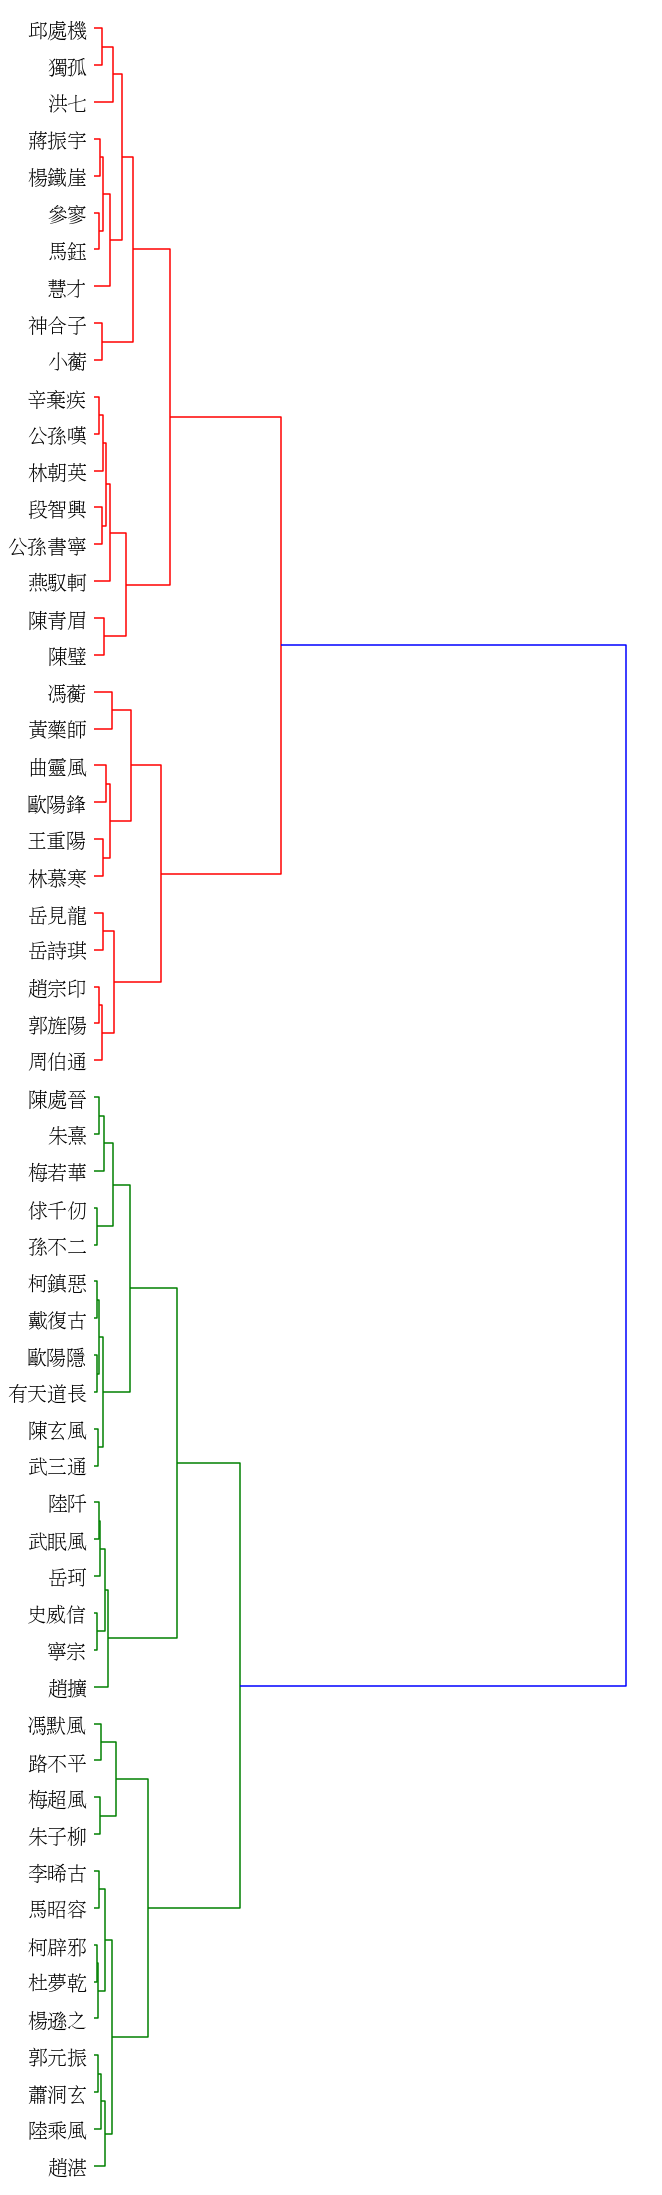

In [31]:
Y = sch.linkage(word_vectors, method="ward")

_, ax = plt.subplots(figsize=(10, 40))

Z = sch.dendrogram(Y, orientation='right')
idx = Z['leaves']

ax.set_xticks([])
ax.set_yticklabels(all_names[idx], 
                  fontproperties=font_chinese)
ax.set_frame_on(False)

plt.show()

In [1]:
import pandas as pd

from scattertext import CorpusFromParsedDocuments
from scattertext import chinese_nlp
from scattertext import produce_scattertext_explorer


Using TensorFlow backend.
/Users/cch/anaconda36/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [18]:
def main():
	df = pd.read_csv('novels/射雕-1.txt')
	df['text'] = df['text'].apply(chinese_nlp)
	corpus = CorpusFromParsedDocuments(df,
	                                   category_col='novel',
	                                   parsed_col='text').build()
	html = produce_scattertext_explorer(corpus,
	                                    category='Pre-Legends of the Condor Heroes',
	                                    category_name='Pre-Legends of the Condor Heroes',
	                                    not_category_name='Legends of the Condor Heroes',
	                                    width_in_pixels=1000,
	                                    metadata=df['novel'],
	                                    asian_mode=True)
	open('./demo_chinese.html', 'w').write(html)
	print('Open ./demo_chinese.html in Chrome or Firefox.')

In [ ]:
main()

Scatter of Keywords
---
<img src="scattertext.png" />